# Data Science Final Project

**Michael Maldonado**<br>


Importing Packages

In [1791]:
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

import numpy as np

import glob
from datetime import datetime

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

import japanize_matplotlib

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans

In [1201]:
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 200

Heatmap Creation Helper functions

In [1505]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

Initializing Spotipy API keys

In [1131]:
SPOTIPY_CLIENT_ID = "fc15dcca96fe41d8a33f50f92d7404f9"
SPOTIPY_CLIENT_SECRET = "5ba0b981b2674a9f981d80700f69acb9"

auth_manager = SpotifyClientCredentials(SPOTIPY_CLIENT_ID, SPOTIPY_CLIENT_SECRET)
sp = spotipy.Spotify(auth_manager = auth_manager)

Finding all "endsong" JSON files, loading them in separate dataframes and concatenating them all together

In [1132]:
dfs = []

for file in glob.glob('MyData/endsong*.json'):
    data = pd.read_json(file)
    dfs.append(data)
    
all_songs = pd.concat(dfs)

In [2]:
num_songs = len(all_songs.index)
print(num_songs)

NameError: name 'all_songs' is not defined

### Cleaning and renaming data

**Dropping columns that are not relevant to this analysis**

In [1134]:
all_songs = all_songs.drop(columns = ["conn_country", 
                                      "ip_addr_decrypted", 
                                      "user_agent_decrypted", 
                                      "episode_name", 
                                      "episode_show_name", 
                                      "spotify_episode_uri", 
                                      "offline_timestamp", 
                                      "username", 
                                      "platform", 
                                      "skipped", 
                                      "offline", 
                                      "incognito_mode"])

**Renaming columns to shorter names**

In [1135]:
all_songs = all_songs.rename(columns = {"master_metadata_track_name": "track_name", 
                                        "master_metadata_album_artist_name": "artist_name", 
                                        "master_metadata_album_album_name": "album_name", 
                                        "spotify_track_uri": "uri"})

**Changing types to be more representative of the actual value**

In [1136]:
all_songs = all_songs.astype({"track_name": str, 
                              "artist_name": str, 
                              "album_name": str, 
                              "uri": str, 
                              "reason_start": str, 
                              "reason_end": str})

In [1137]:
all_songs.dtypes

ts              object
ms_played        int64
track_name      object
artist_name     object
album_name      object
uri             object
reason_start    object
reason_end      object
shuffle           bool
dtype: object

In [1399]:
all_songs["ts"] = all_songs["ts"].dt.tz_convert('US/Central')

**Converting field `ts` containing timestamp of when song was played to a Python `datetime` object in the dataframe**

In [1138]:
all_songs["ts"] = pd.to_datetime(all_songs["ts"])


,ts,ms_played,track_name,artist_name,album_name,uri,reason_start,reason_end,shuffle
0,2018-12-31 08:22:13+00:00,6357,Electrify,Shiro Schwarz,Street Beat,spotify:track:0EujJrnoynjEagj1TWclkw,clickrow,fwdbtn,True
1,2021-03-30 00:27:25+00:00,11080,Oh My...,Toby Fox,UNDERTALE Soundtrack,spotify:track:6CBsGV6sv811sRb4sNBmcl,trackdone,fwdbtn,False
2,2018-06-05 02:52:25+00:00,232091,Orbit (feat. Richard Caddock),WRLD,Orbit (feat. Richard Caddock),spotify:track:3BkLpheTPPxLrAvi0dHId8,trackdone,logout,False
3,2021-04-25 21:27:05+00:00,2420,The Poetry Of August,Lamp,The Poetry Of August,spotify:track:38mF9ahDeZLbI1CTxbSo3V,clickrow,endplay,False
4,2019-09-12 14:59:47+00:00,25569,Fox,Shirobon,Dimensions,spotify:track:2KORn4JKTJvUMu8E3EnT5K,trackdone,backbtn,False


In [1423]:
all_songs

,ts,ms_played,track_name,artist_name,album_name,uri,reason_start,reason_end,shuffle
0,2018-12-31 02:22:13-06:00,6357,Electrify,Shiro Schwarz,Street Beat,spotify:track:0EujJrnoynjEagj1TWclkw,clickrow,fwdbtn,True
1,2021-03-29 19:27:25-05:00,11080,Oh My...,Toby Fox,UNDERTALE Soundtrack,spotify:track:6CBsGV6sv811sRb4sNBmcl,trackdone,fwdbtn,False
2,2018-06-04 21:52:25-05:00,232091,Orbit (feat. Richard Caddock),WRLD,Orbit (feat. Richard Caddock),spotify:track:3BkLpheTPPxLrAvi0dHId8,trackdone,logout,False
3,2021-04-25 16:27:05-05:00,2420,The Poetry Of August,Lamp,The Poetry Of August,spotify:track:38mF9ahDeZLbI1CTxbSo3V,clickrow,endplay,False
4,2019-09-12 09:59:47-05:00,25569,Fox,Shirobon,Dimensions,spotify:track:2KORn4JKTJvUMu8E3EnT5K,trackdone,backbtn,False
...,...,...,...,...,...,...,...,...,...
16835,2018-03-29 00:17:49-05:00,11586,Need You Now,Hot Chip,Why Make Sense? (Definitive Version),spotify:track:5MRYyecW552BEq2nRBfIQX,fwdbtn,fwdbtn,False
16836,2018-08-08 23:51:20-05:00,9740,Dark Days - Classixx Remix,Local Natives,Dark Days,spotify:track:0EH8lce65ehgSVbMwTFMnY,fwdbtn,fwdbtn,True
16837,2021-07-27 02:27:47-05:00,160,トゥイー・ボックスの人形劇場,sasakure.UK,トンデモ未来空奏図,spotify:track:6SEpog7tX8bReMw2wHzcFH,backbtn,backbtn,False
16838,2021-05-07 20:47:39-05:00,358343,ajabollamente,Shohei Amimori,PataMusic,spotify:track:0yNLQUwYO4weCfYUonwuxt,trackdone,trackdone,False


#### Creating new Dataframe with Track features of every song in all_songs, getting data from Spotify API

Small Function that will be used to flatten the genre list of lists for all artists for each track

In [858]:
def flatten(t: list) -> list:
    return [item for sublist in t for item in sublist]

In [863]:
all_features = pd.DataFrame()

for i in range(0, num_songs - 1, 100):
    # print("{0} to {1}".format(i, (i + 100) - 1))
    
    ids_list = all_songs.iloc[i:i + 100, 5].tolist()
    
    # If list of ids in batches of 100 contains a None value
    if (None in ids_list or bool in ids_list):
        # Iterate through list of ids
        for curr_id in ids_list:
            # For all None ids append an empty Series
            if (curr_id is None or curr_id is bool):
                all_features = all_features.append(pd.Series(), ignore_index = True)
            else:
                all_features = all_features.append(pd.Series(sp.audio_features(curr_id)), ignore_index = True)
    
    # Else All ids are valid
    else:
        temp_features_dicts = sp.audio_features(ids_list) 
        
        # If list of Dicts contains a None value
        if (None in temp_features_dicts):
            # Iterate through list of Dicts
            for curr_dict in temp_features_dicts:
                # For all None vals append an empty Series
                if (curr_dict is None):
                    all_features = all_features.append(pd.Series(), ignore_index = True)
                else:
                    all_features = all_features.append(pd.Series(curr_dict), ignore_index = True)
       
        # List of Dicts contains all valid values
        else:
            all_features = all_features.append(pd.DataFrame(temp_features_dicts), ignore_index = True)

# Appending remainder of ids
if (i < num_songs - 1):
    # print("{0} to {1}".format(i, (i + num_songs - i) - 1))
    
    ids_list = all_songs.iloc[i:(i + num_songs - i), 5].tolist()
    # If list of ids in final batch contains a None value
    if (None in ids_list or bool in ids_list):
        # Iterate through list of ids
        for curr_id in ids_list:
            # For all None ids append an empty Series
            if (curr_id is None or curr_id is bool):
                all_features = all_features.append(pd.Series(), ignore_index = True)
            else:
                all_features = all_features.append(pd.Series(sp.audio_features(curr_id)), ignore_index = True)
    
    # Else All ids are valid
    else:
        temp_features_dicts = sp.audio_features(ids_list) 
        
        # If list of Dicts contains a None value
        if (None in temp_features_dicts or bool in temp_features_dicts):
            # Iterate through list of Dicts
            for curr_dict in temp_features_dicts:
                # For all None vals append an empty Series
                if (curr_dict is None or curr_dict is bool):
                    all_features = all_features.append(pd.Series(), ignore_index = True)
                else:
                    all_features = all_features.append(pd.Series(curr_dict), ignore_index = True)
       
        # List of Dicts contains all valid values
        else:
            all_features = all_features.append(pd.DataFrame(temp_features_dicts), ignore_index = True)


/var/folders/5g/d550v_g13flgl3t8c1gd39r80000gn/T/ipykernel_80077/21801141.py:28: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  all_features = all_features.append(pd.Series(), ignore_index = True)


AttributeError: 'bool' object has no attribute 'split'

#### Cleaning up `all_features` Dataframe

**Dropping columns that are not relevant to this analysis**

In [1148]:
all_features = all_features.drop(columns = ["type", 
                                            "id", 
                                            "track_href", 
                                            "analysis_url",
                                            "time_signature"])

KeyError: "['type' 'id' 'track_href' 'analysis_url'] not found in axis"

In [1229]:
all_features

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,uri,duration_ms
0,0.908,0.763,10.0,-4.525,0.0,0.0430,0.060600,0.35500,0.0332,0.935,120.019,spotify:track:0EujJrnoynjEagj1TWclkw,198426.0
1,0.000,0.400,9.0,-14.282,0.0,0.0000,0.991000,0.67800,0.3460,0.000,0.000,spotify:track:6CBsGV6sv811sRb4sNBmcl,14483.0
2,0.571,0.620,6.0,-5.791,1.0,0.0267,0.005440,0.00000,0.0923,0.625,150.012,spotify:track:3BkLpheTPPxLrAvi0dHId8,240000.0
3,0.356,0.414,9.0,-5.853,1.0,0.0293,0.893000,0.00678,0.1330,0.095,143.135,spotify:track:38mF9ahDeZLbI1CTxbSo3V,367760.0
4,0.579,0.971,10.0,-3.994,0.0,0.0633,0.000073,0.98000,0.2370,0.558,138.010,spotify:track:2KORn4JKTJvUMu8E3EnT5K,316522.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
151292,0.693,0.712,7.0,-9.238,1.0,0.0469,0.012000,0.69700,0.1100,0.150,120.016,spotify:track:5MRYyecW552BEq2nRBfIQX,285565.0
151293,0.636,0.733,2.0,-6.996,1.0,0.0413,0.010300,0.71600,0.1290,0.819,114.976,spotify:track:0EH8lce65ehgSVbMwTFMnY,243000.0
151294,0.670,0.889,1.0,-2.770,1.0,0.0376,0.243000,0.00390,0.3120,0.963,170.016,spotify:track:6SEpog7tX8bReMw2wHzcFH,238347.0
151295,0.512,0.649,0.0,-7.004,0.0,0.0270,0.084900,0.86300,0.1610,0.422,154.997,spotify:track:0yNLQUwYO4weCfYUonwuxt,358343.0


In [1795]:
all_features_ML = all_features.drop(columns = ["uri", "mode", "key", "duration_ms", "speechiness", "acousticness", "instrumentalness", "liveness", "tempo"])

Fill in Missing values from all_features

In [1796]:
all_features_ML = all_features_ML.fillna(0)

In [1]:
all_features_ML.head()

NameError: name 'all_features_ML' is not defined

**Standardizing the features**

In [1798]:
scaler = preprocessing.StandardScaler().fit(all_features_ML)

In [1799]:
scaler.mean_

array([ 0.56994181,  0.67980223, -7.69272011,  0.47023651])

In [1800]:
scaler.scale_

array([0.16131069, 0.22064521, 4.78126865, 0.26065267])

In [1801]:
all_features_SCALED = scaler.transform(all_features_ML)
all_features_SCALED = pd.DataFrame(all_features_SCALED, columns = all_features_ML.columns)

In [1802]:
all_features_SCALED.head()

,danceability,energy,loudness,valence
0,2.095696,0.377066,0.662527,1.783076
1,-3.533193,-1.268109,-1.378145,-1.804073
2,0.006560,-0.271033,0.397744,0.593754
3,-1.326272,-1.204659,0.384777,-1.439604
4,0.056154,1.319756,0.773586,0.336707


Standardized Features Scatterplot

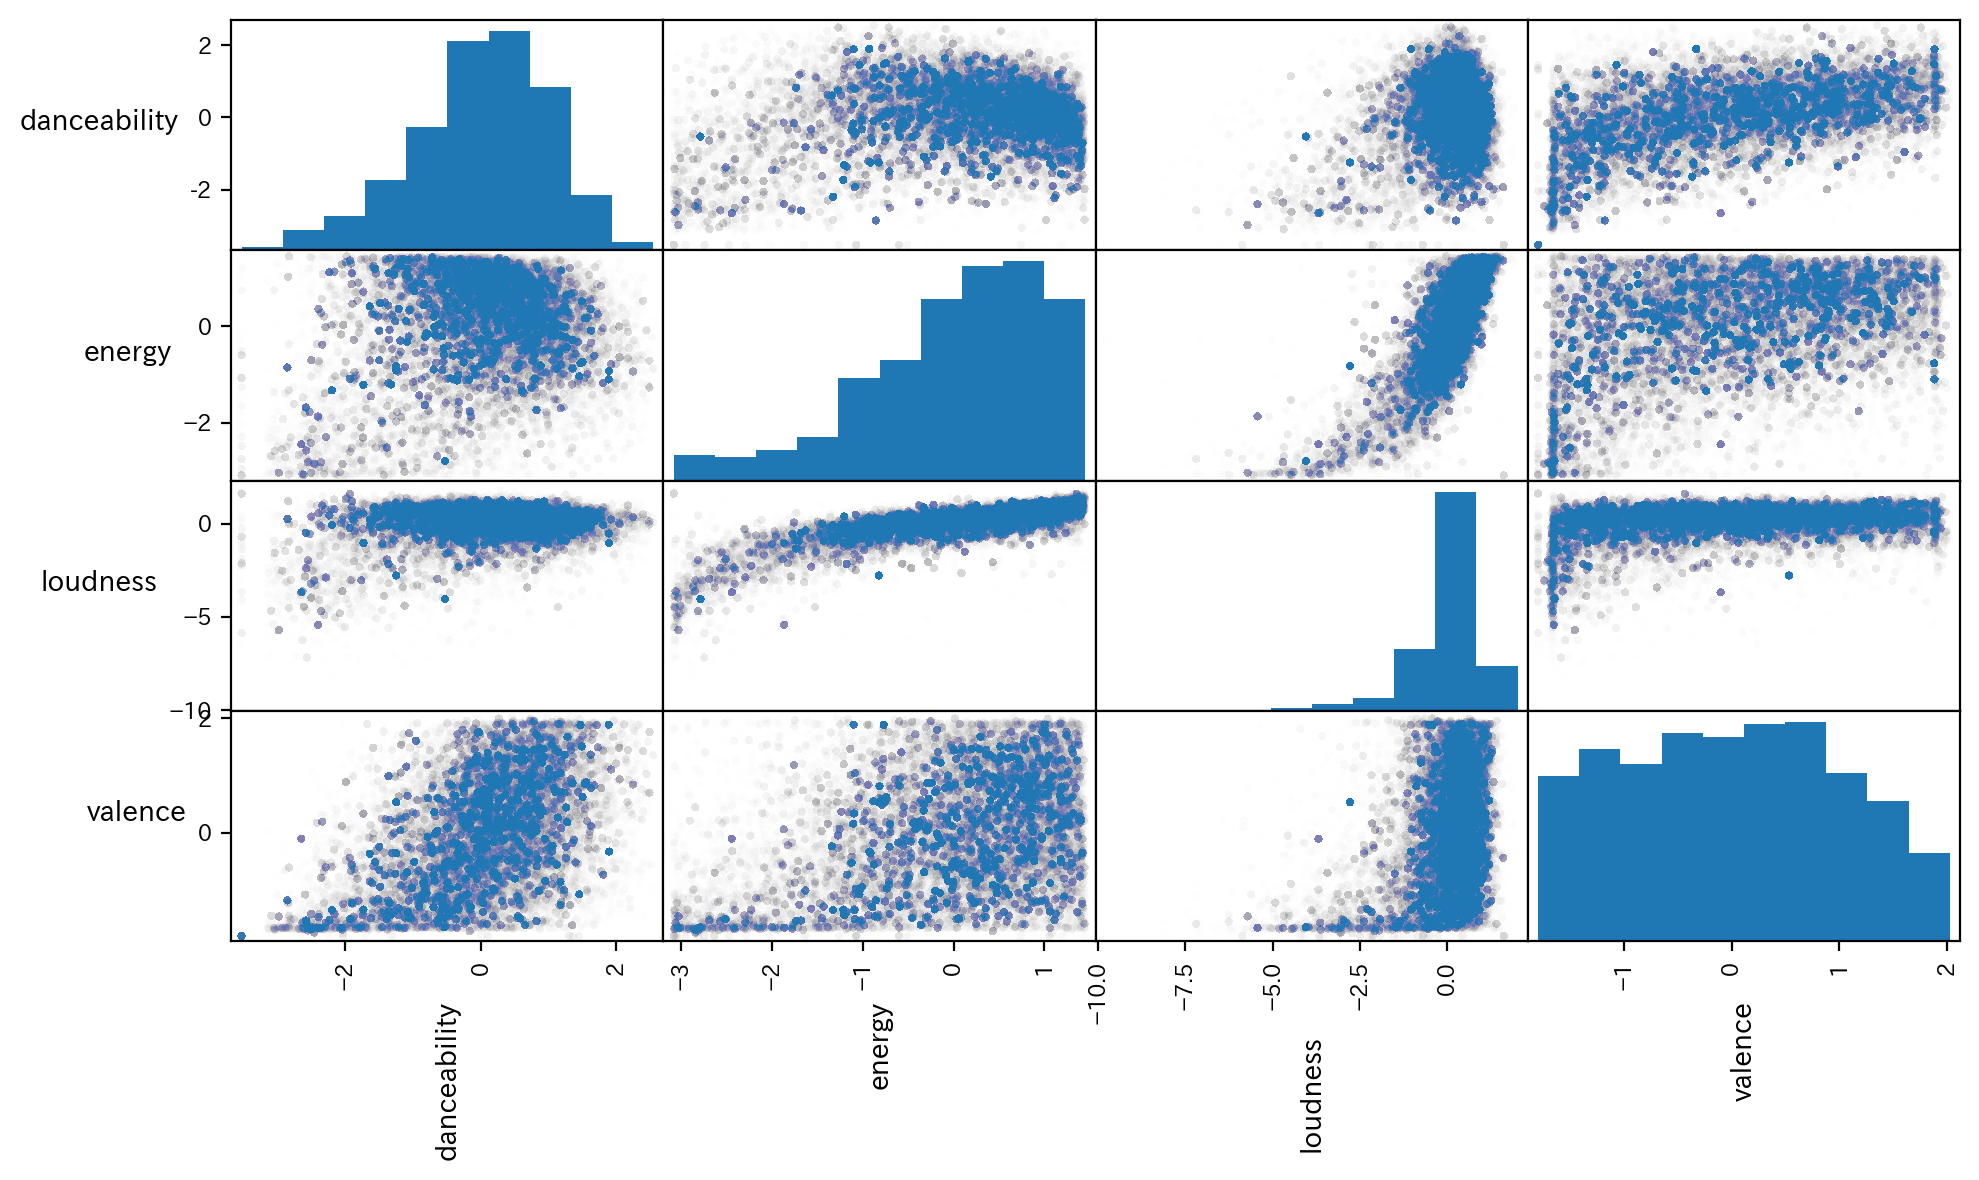

In [1803]:
axes = pd.plotting.scatter_matrix(all_features_SCALED, alpha=0.002)
for ax in axes.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')

plt.tight_layout()
plt.gcf().subplots_adjust(wspace=0, hspace=0)
plt.show()

**Correlation of Standardized Features**

TypeError: 'dict' object is not callable

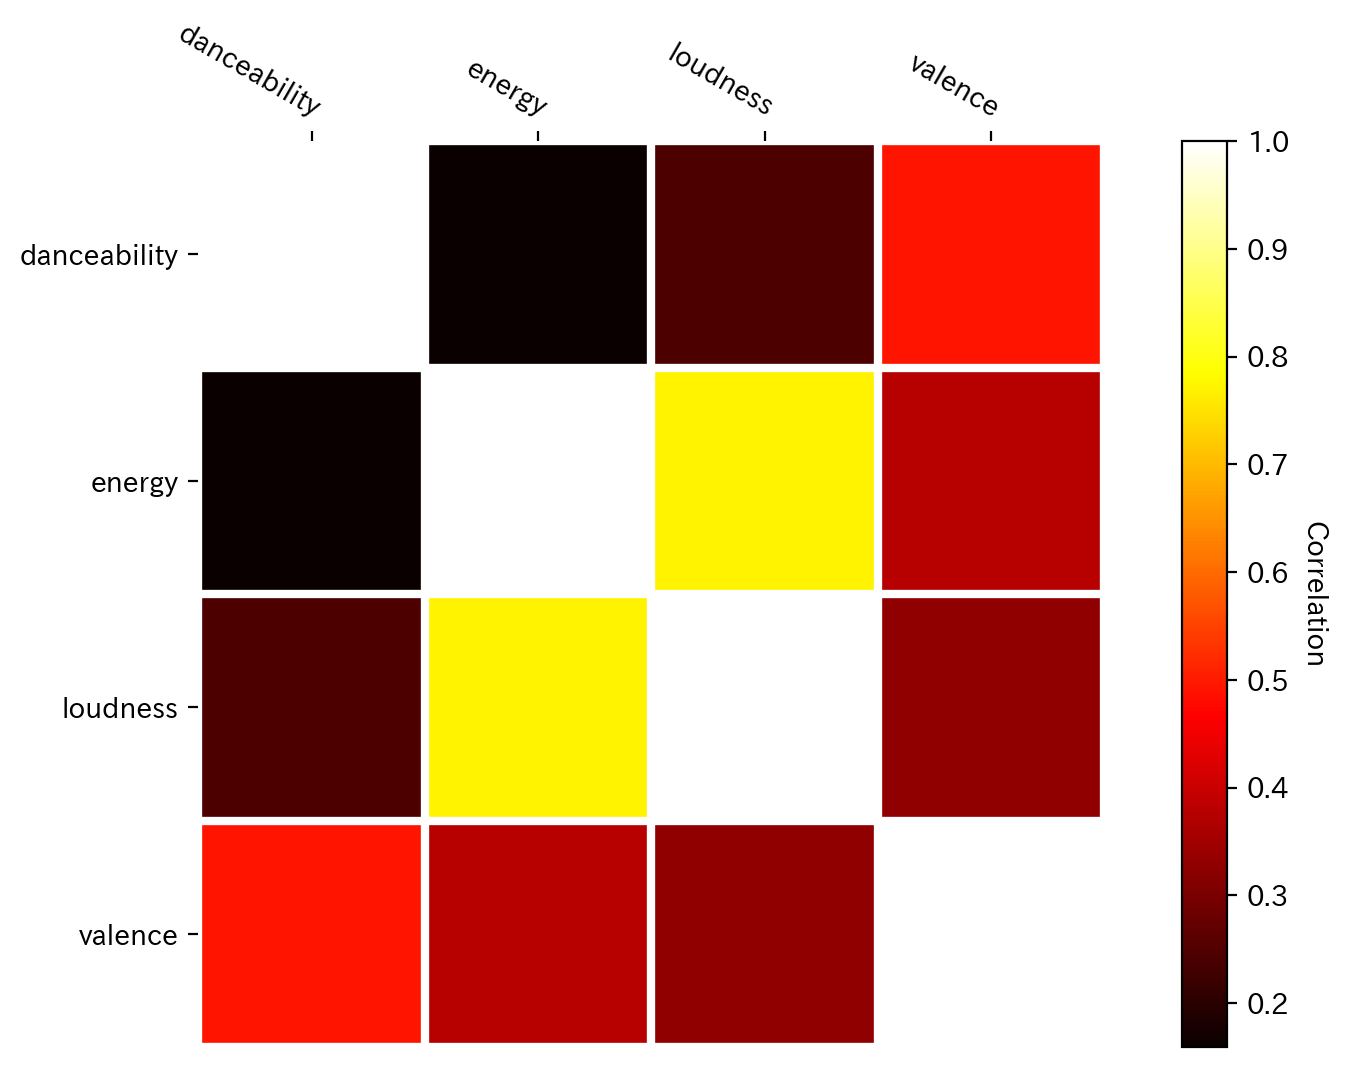

In [1804]:
fig, ax = plt.subplots()
im, cbar = heatmap(all_features_SCALED.corr(), all_features_SCALED.columns, all_features_SCALED.columns, ax = ax, cbarlabel="Correlation")
texts = annotate_heatmap(im, valfmt="{x:.1f} t")

fig.tight_layout()
plt.show()

**PCA on Standardized features**

In [1805]:
all_features_SCALED

,danceability,energy,loudness,valence
0,2.095696,0.377066,0.662527,1.783076
1,-3.533193,-1.268109,-1.378145,-1.804073
2,0.006560,-0.271033,0.397744,0.593754
3,-1.326272,-1.204659,0.384777,-1.439604
4,0.056154,1.319756,0.773586,0.336707
...,...,...,...,...
151292,0.762864,0.145926,-0.323195,-1.228595
151293,0.409509,0.241101,0.145719,1.338039
151294,0.620282,0.948118,1.029585,1.890499
151295,-0.359194,-0.139601,0.144045,-0.185060


In [1813]:
pca = PCA(n_components = 3)
principalComponents = pca.fit_transform(all_features_SCALED)

features_PC = pd.DataFrame(principalComponents)

In [1814]:
features_PC.head()

,0,1,2
0,-2.234058,1.769606,-0.124402
1,3.688440,-2.069017,1.138069
2,-0.359668,0.227937,0.315541
3,1.650061,-1.154387,-0.416005
4,-1.352229,-0.700656,0.074554


In [1815]:
pca.explained_variance_ratio_.sum()

0.9466808238192326

([<matplotlib.axis.XTick at 0x1e6eefca0>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

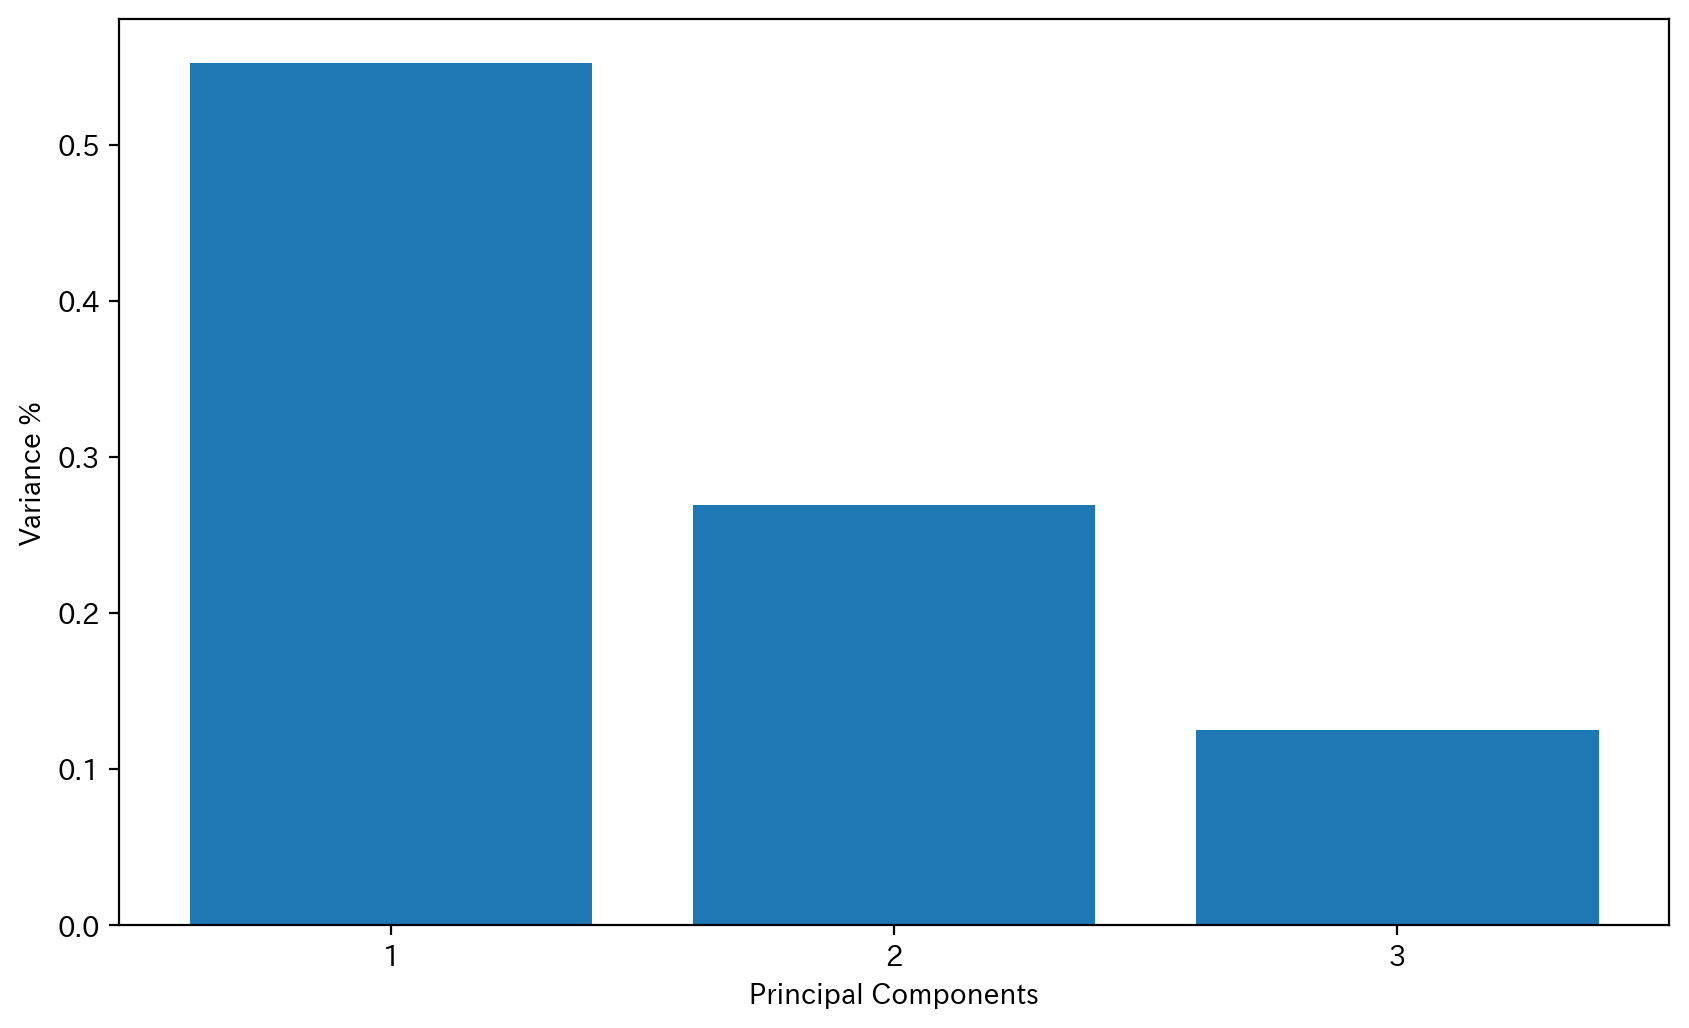

In [1816]:
PC = range(1, pca.n_components_+1)
plt.bar(PC, pca.explained_variance_ratio_)
plt.xlabel('Principal Components')
plt.ylabel('Variance %')
plt.xticks(PC)



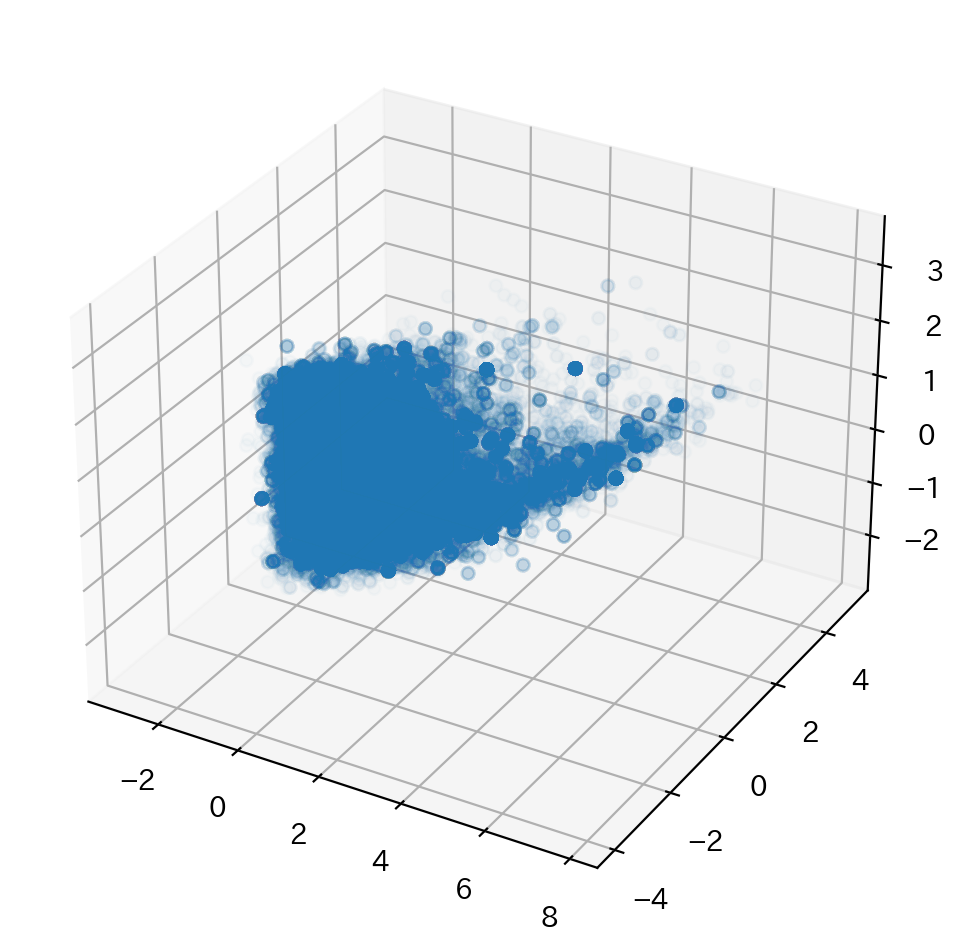

In [1817]:


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

img = ax.scatter(features_PC[0], features_PC[1], features_PC[2], alpha=.02)

plt.show()


# plt.scatter(features_PC[0], features_PC[1], alpha = 0.01)

**Clustering With PCA**

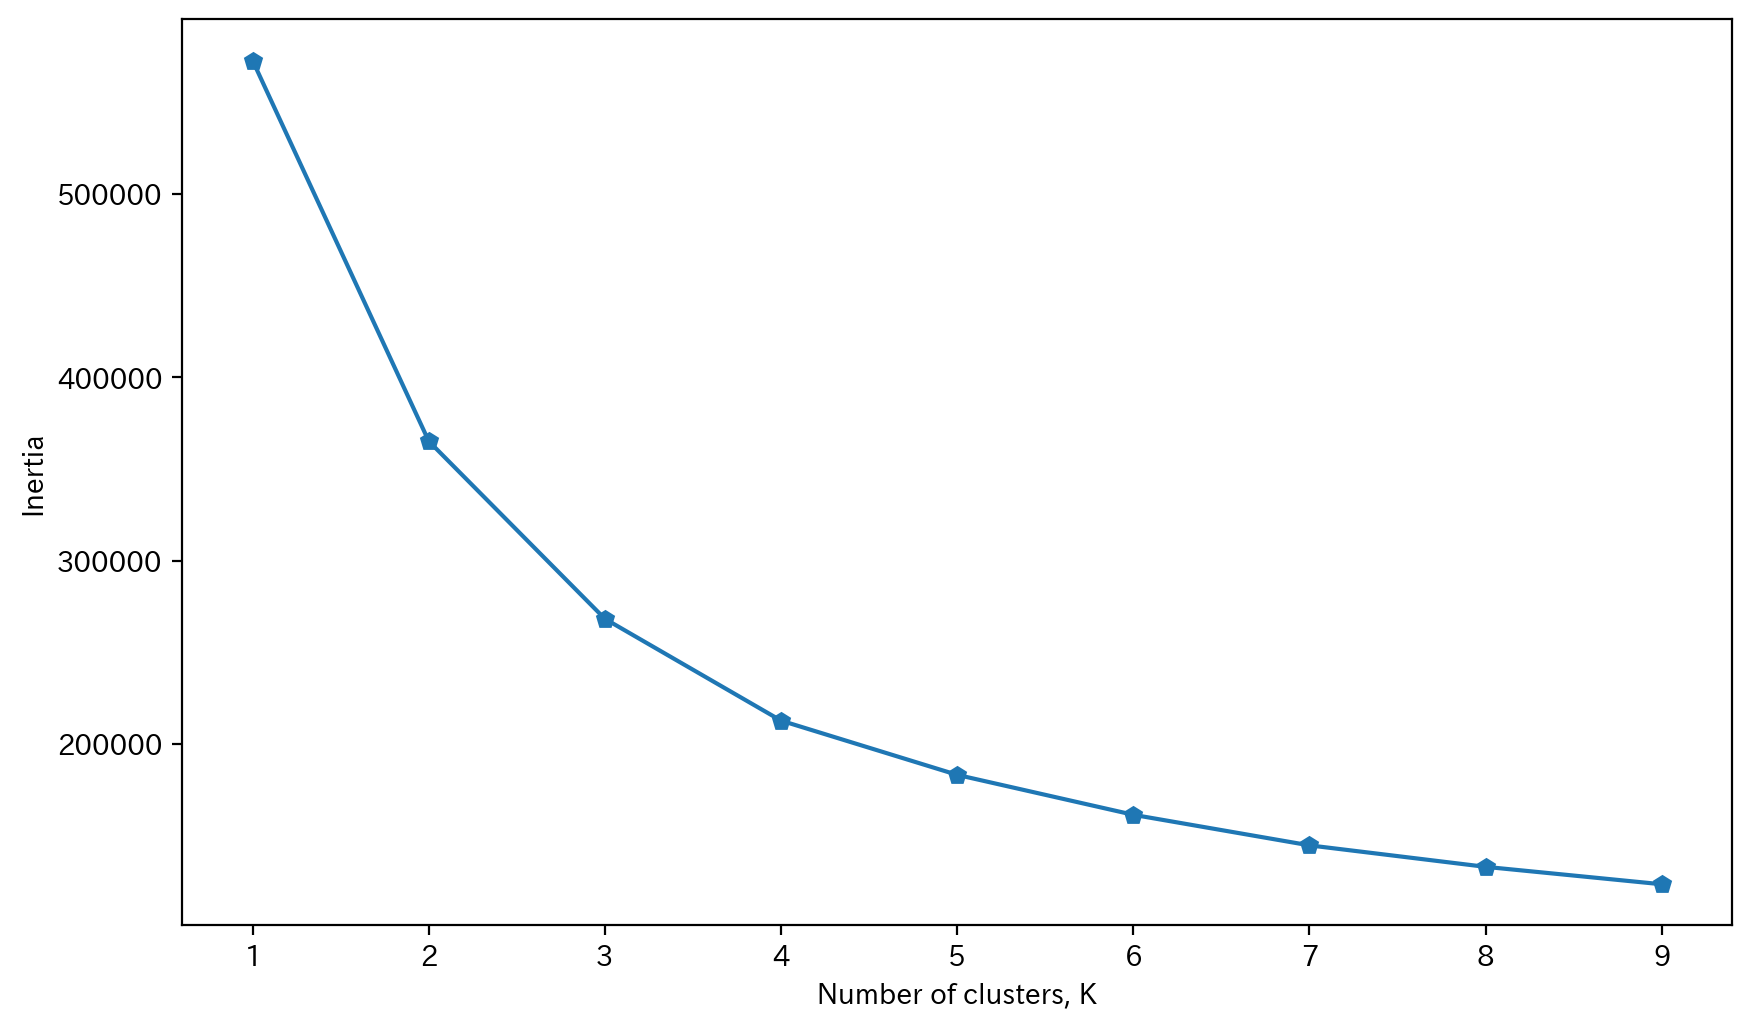

In [1818]:
inertias = []

# Creating 10 K-Mean models while varying the number of clusters (k)
for k in range(1,10):
    model = KMeans(n_clusters = k)
    
    # Fit model to samples
    model.fit(features_PC)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(range(1,10), inertias, '-p')
plt.xlabel('Number of clusters, K')
plt.ylabel('Inertia')
plt.show()

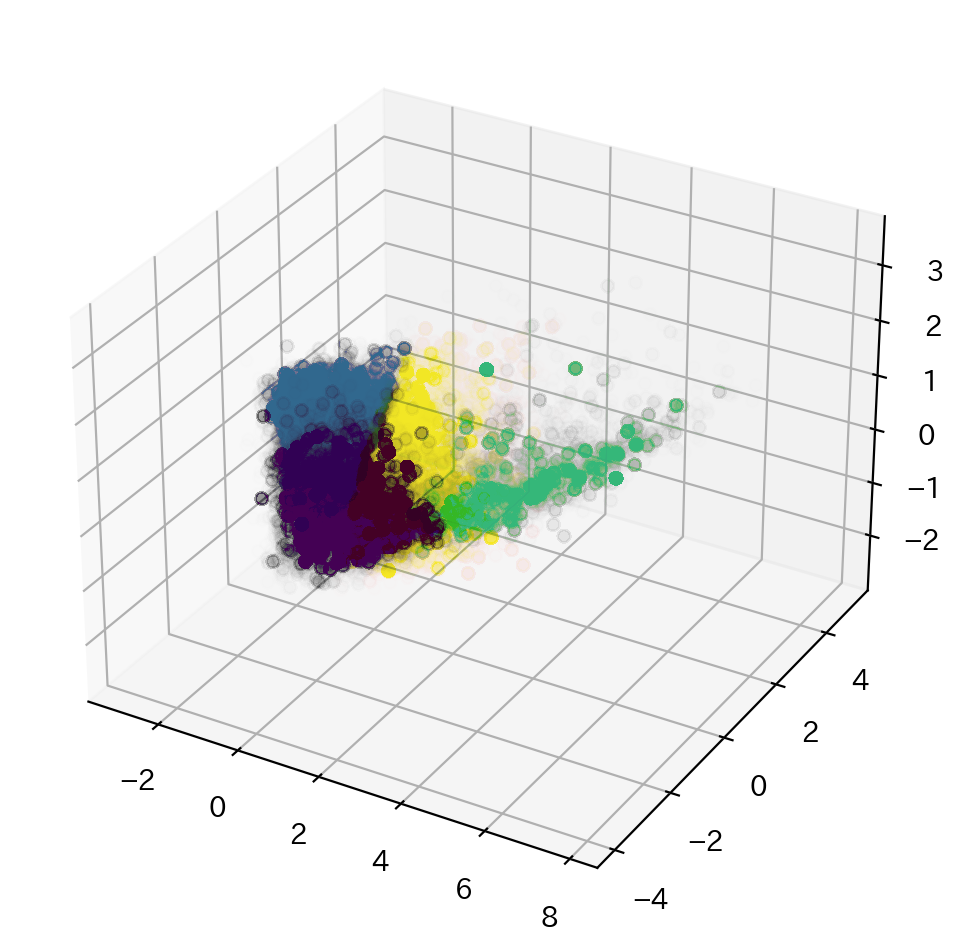

In [1821]:
model = KMeans(n_clusters = 4)
model.fit(all_features_SCALED)

labels = model.predict(all_features_SCALED)

"""
plt.scatter(features_PC[0], features_PC[1], c = labels, cmap = 'viridis')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()


"""
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

img = ax.scatter(features_PC[0], features_PC[1], features_PC[2], c = labels, cmap = 'viridis', alpha=.002)

plt.show()


#### Creating new Dataframe with Track genres of every song in `all_songs`, getting data from Spotify API (NOT WORKING)

In [1213]:
"""
all_genres = pd.DataFrame()

for i in range(0, num_songs - 1, 50):
    temp_track_ids = all_songs.iloc[i: (i + 50), 5].tolist()
    temp_tracks = sp.tracks(temp_track_ids)
    
    for i in range(0, len(temp_tracks["tracks"])):
        temp_artist_ids = []
        temp_genres = []
        
        if (temp_tracks["tracks"][i] is None):
            print("***Track {0} is None***".format(i))
        
        else:
            print("Current Track: {0} : {1}".format(temp_tracks["tracks"][i]["name"], i))
            for j in range(0, len(temp_tracks["tracks"][i]["artists"])):
                print("   Current Artist: {}".format(temp_tracks["tracks"][i]["artists"][j]["name"]))
                if (temp_tracks["tracks"][i]["artists"][j]["id"] is not None):
                    temp_artist_ids.append(temp_tracks["tracks"][i]["artists"][j]["id"])
    
            artists = sp.artists(temp_artist_ids)
            for k in range(0, len(artists["artists"])):
                print("      Current Genres: {}".format(artists["artists"][k]["genres"]))
                temp_genres.append(artists["artists"][k]["genres"])
        
        temp_genres = flatten(temp_genres)
        temp_genres.insert(0, temp_track_ids[i])

        all_genres = all_genres.append(pd.DataFrame(temp_genres).drop_duplicates().T, ignore_index = True)

# Appending remainder of genres
if (i < num_songs - 1):
    temp_track_ids = all_songs.iloc[i: (num_songs - i), 5].tolist()
    temp_tracks = sp.tracks(temp_track_ids)
    
    for i in range(0, len(temp_tracks["tracks"])):
        temp_artist_ids = []
        temp_genres = []
        
        if (temp_tracks["tracks"][i] is None):
            print("***Track {0} is None***".format(i))
        
        else:
            print("Current Track: {0} : {1}".format(temp_tracks["tracks"][i]["name"], i))
            for j in range(0, len(temp_tracks["tracks"][i]["artists"])):
                print("   Current Artist: {}".format(temp_tracks["tracks"][i]["artists"][j]["name"]))
                if (temp_tracks["tracks"][i]["artists"][j]["id"] is not None):
                    temp_artist_ids.append(temp_tracks["tracks"][i]["artists"][j]["id"])
    
            artists = sp.artists(temp_artist_ids)
            for k in range(0, len(artists["artists"])):
                print("      Current Genres: {}".format(artists["artists"][k]["genres"]))
                temp_genres.append(artists["artists"][k]["genres"])
        
        temp_genres = flatten(temp_genres)
        temp_genres.insert(0, temp_track_ids[i])

        all_genres = all_genres.append(pd.DataFrame(temp_genres).drop_duplicates().T, ignore_index = True)
"""

'\nall_genres = pd.DataFrame()\n\nfor i in range(0, num_songs - 1, 50):\n    temp_track_ids = all_songs.iloc[i: (i + 50), 5].tolist()\n    temp_tracks = sp.tracks(temp_track_ids)\n    \n    for i in range(0, len(temp_tracks["tracks"])):\n        temp_artist_ids = []\n        temp_genres = []\n        \n        if (temp_tracks["tracks"][i] is None):\n            print("***Track {0} is None***".format(i))\n        \n        else:\n            print("Current Track: {0} : {1}".format(temp_tracks["tracks"][i]["name"], i))\n            for j in range(0, len(temp_tracks["tracks"][i]["artists"])):\n                print("   Current Artist: {}".format(temp_tracks["tracks"][i]["artists"][j]["name"]))\n                if (temp_tracks["tracks"][i]["artists"][j]["id"] is not None):\n                    temp_artist_ids.append(temp_tracks["tracks"][i]["artists"][j]["id"])\n    \n            artists = sp.artists(temp_artist_ids)\n            for k in range(0, len(artists["artists"])):\n               

In [1180]:
genre_counts = pd.Series()

for column in all_genres.columns[1:]:
    genre_counts = pd.concat([genre_counts, all_genres[column].value_counts()])


/var/folders/5g/d550v_g13flgl3t8c1gd39r80000gn/T/ipykernel_80077/3546665245.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  genre_counts = pd.Series()


In [1185]:
genre_counts = genre_counts.sort_values(ascending = False)

In [1214]:
genre_counts[genre_counts > 500]

alternative dance           3288
edm                         2060
electro house               1918
complextro                  1866
vocaloid                    1736
bitpop                      1735
future bass                 1676
chiptune                    1635
indie game soundtrack       1393
future bass                 1372
future bass                 1312
filter house                1274
electro                     1254
gaming edm                  1202
japanese alternative pop    1087
indie rock                  1043
chillwave                    970
future funk                  833
chiptune                     772
video game music             741
indie game soundtrack        734
kawaii future bass           699
indie soul                   661
indietronica                 641
vapor soul                   604
filter house                 596
rock                         593
future bass                  587
electropop                   582
modern rock                  578
city pop  

### Distributions of Data

#### Distribution of `all_songs` data

`ts` per year

[]

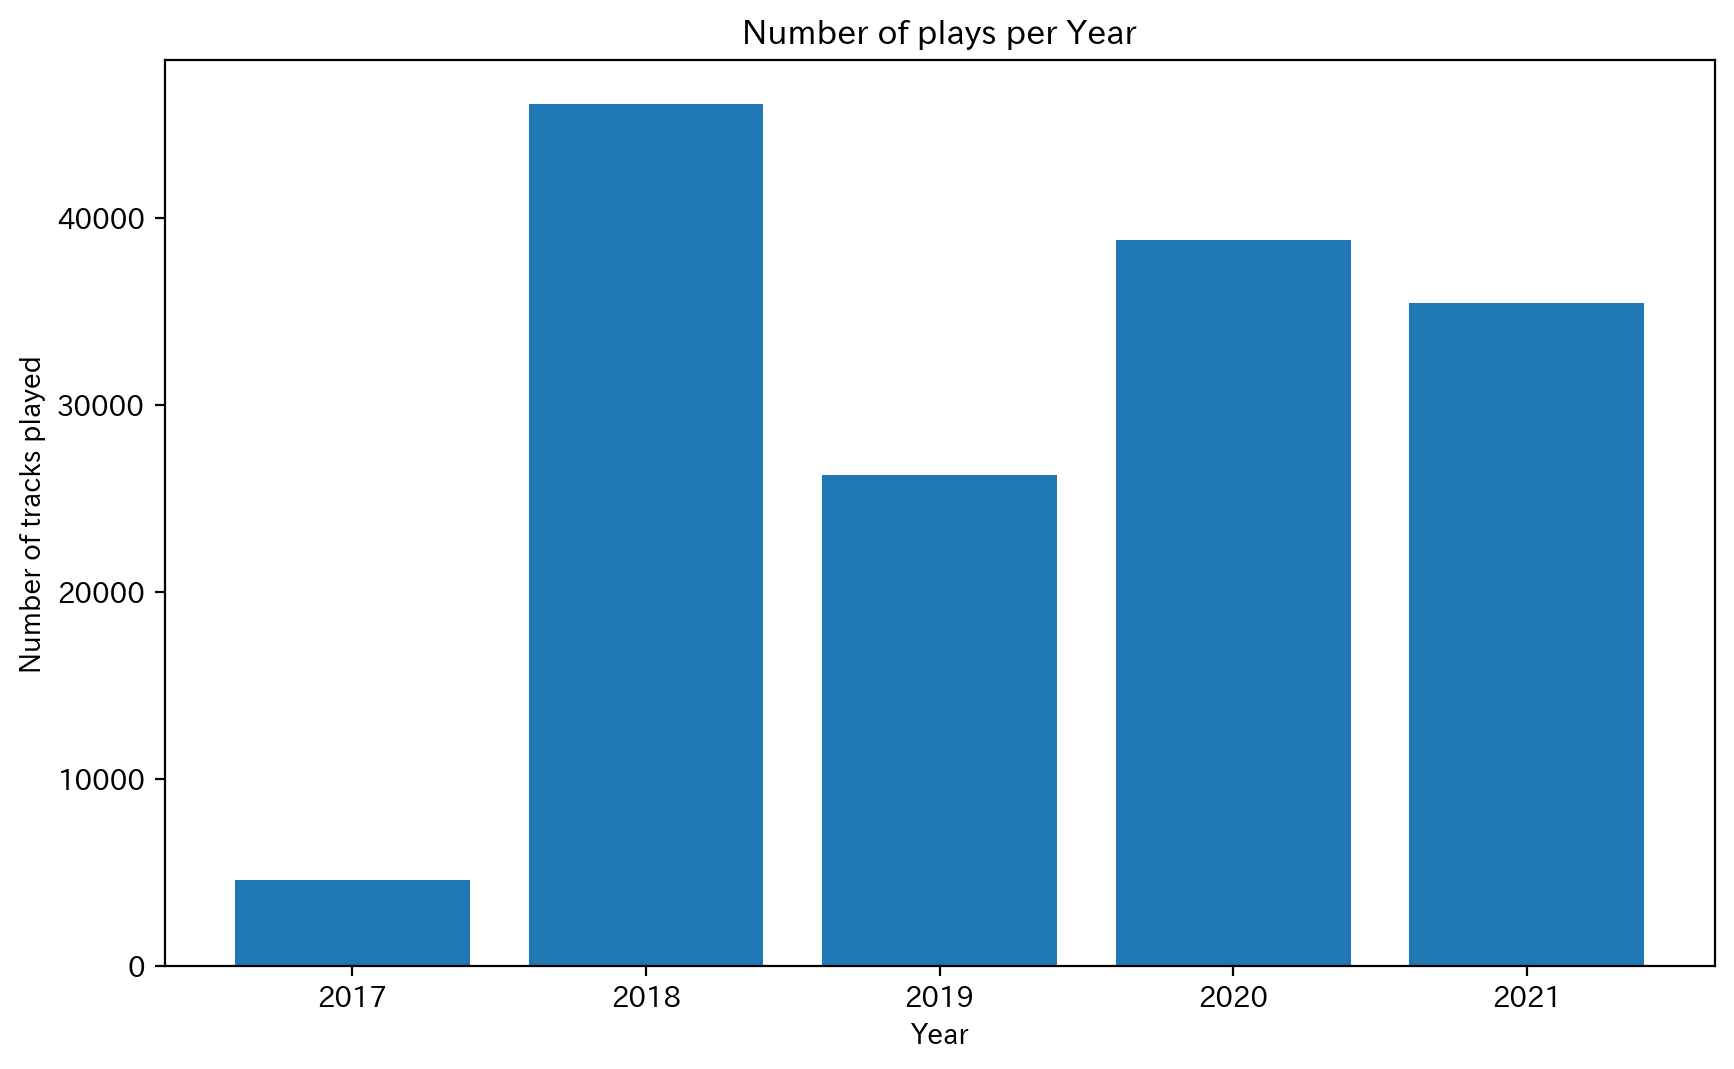

In [1401]:
plays_per_year = all_songs["ts"].dt.strftime('%Y').value_counts().sort_index()
plt.bar(plays_per_year.index, plays_per_year)
plt.xlabel("Year")
plt.ylabel("Number of tracks played")
plt.title("Number of plays per Year")
plt.plot()

`ts` Cumulative Monthly

In [1402]:
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
          "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

In [1403]:
all_plays_per_month = all_songs["ts"].dt.strftime('%B').value_counts()

all_plays_per_month.sort_index()

"""
plt.bar(plays_per_month.index, plays_per_month)
plt.xlabel("Month")
plt.ylabel("Number of tracks played")
plt.title("Number of plays per Month")
plt.xticks(rotation = 45)
plt.plot()
"""

all_plays_per_month

April        17566
January      14639
May          14478
March        14091
December     13975
February     12677
June         11928
July         11722
October      10860
August       10471
September    10341
November      8549
Name: ts, dtype: int64

`ts` monthly plays per year

[]

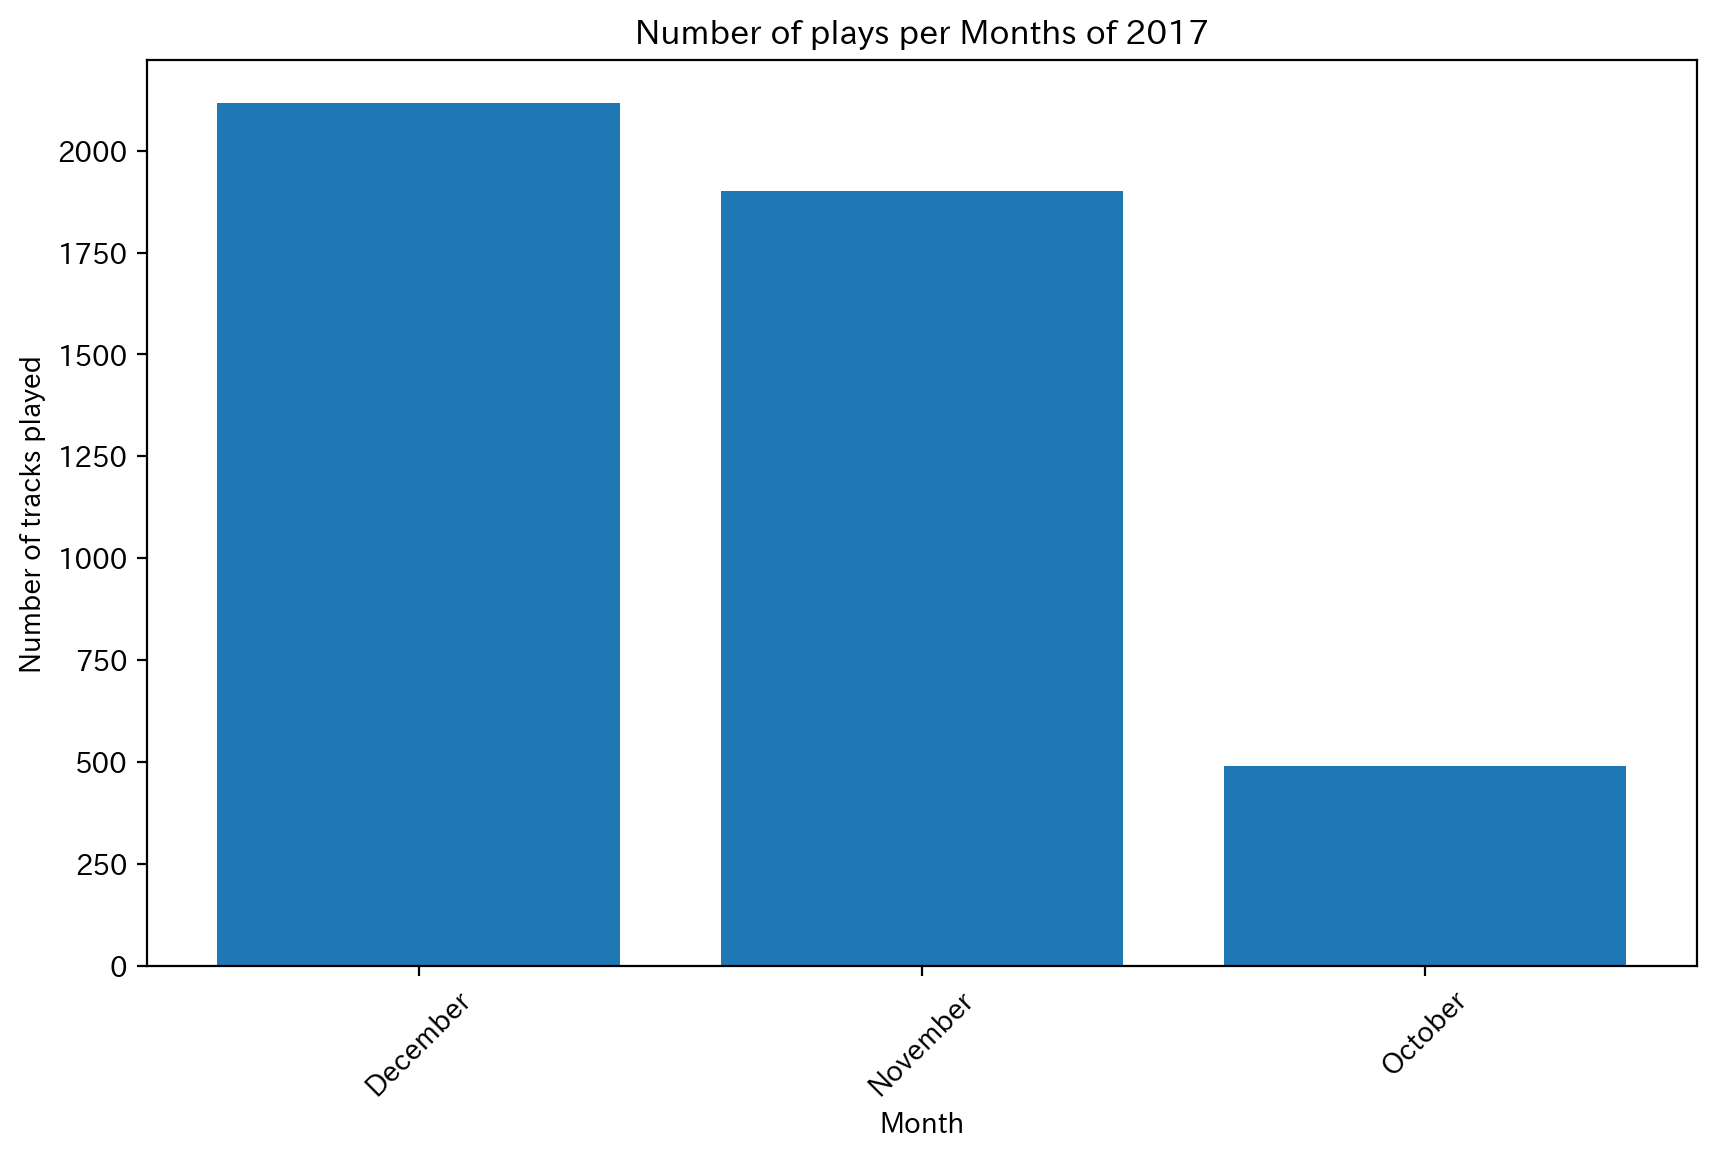

In [1404]:
plays_per_month_2017 = all_songs["ts"][(all_songs["ts"] > '2017-1-1') & (all_songs["ts"] <= '2017-12-31')].dt.strftime('%B').value_counts()

plt.bar(plays_per_month_2017.index, plays_per_month_2017)
plt.xlabel("Month")
plt.ylabel("Number of tracks played")
plt.title("Number of plays per Months of 2017")
plt.xticks(rotation = 45)
plt.plot()

`ms_played` distribution

[]

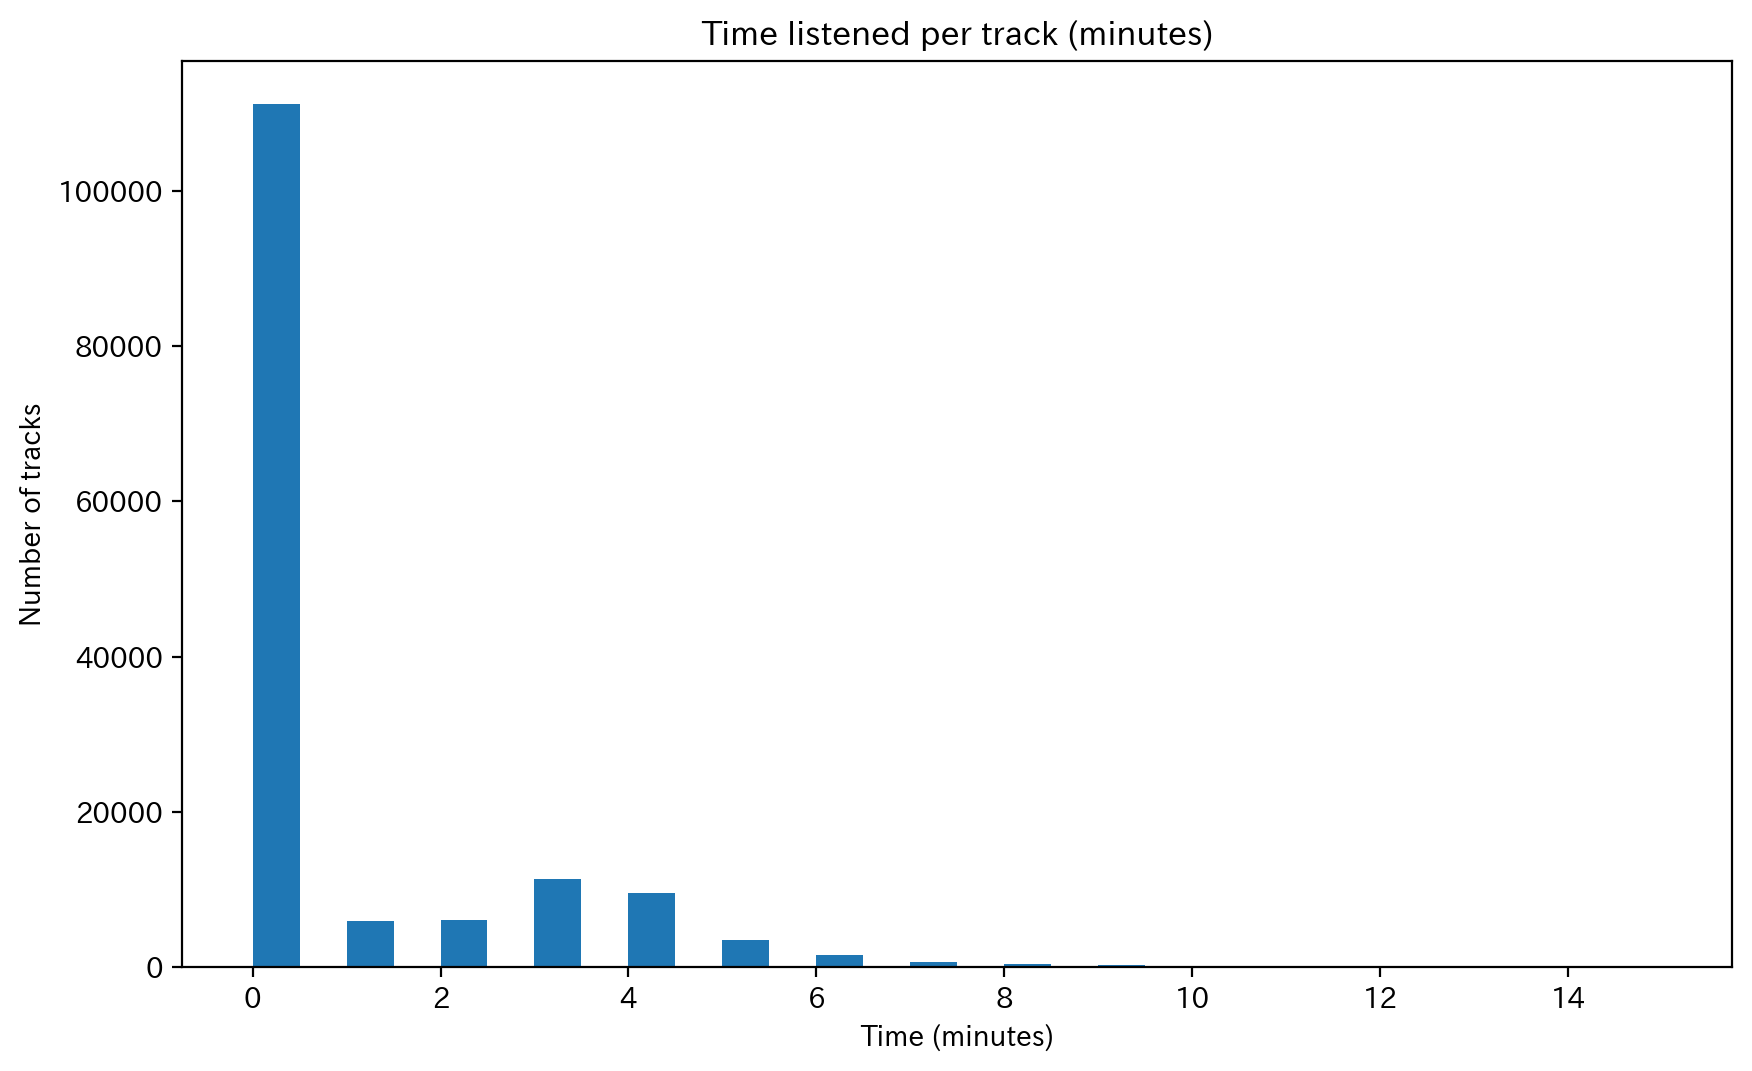

In [1405]:
all_times_seconds = pd.to_timedelta(all_songs["ms_played"], unit = 'ms')
plt.hist(all_times_seconds.astype('timedelta64[m]'), range = (0, 15), bins = 30)
plt.title("Time listened per track (minutes)")
plt.xlabel("Time (minutes)")
plt.ylabel("Number of tracks")
plt.plot()

`reason_start` and `reason_end` distribution

/var/folders/5g/d550v_g13flgl3t8c1gd39r80000gn/T/ipykernel_80077/4179607588.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(all_songs["reason_start"].value_counts().index, rotation=45)
/var/folders/5g/d550v_g13flgl3t8c1gd39r80000gn/T/ipykernel_80077/4179607588.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(all_songs["reason_end"].value_counts().index, rotation=45)


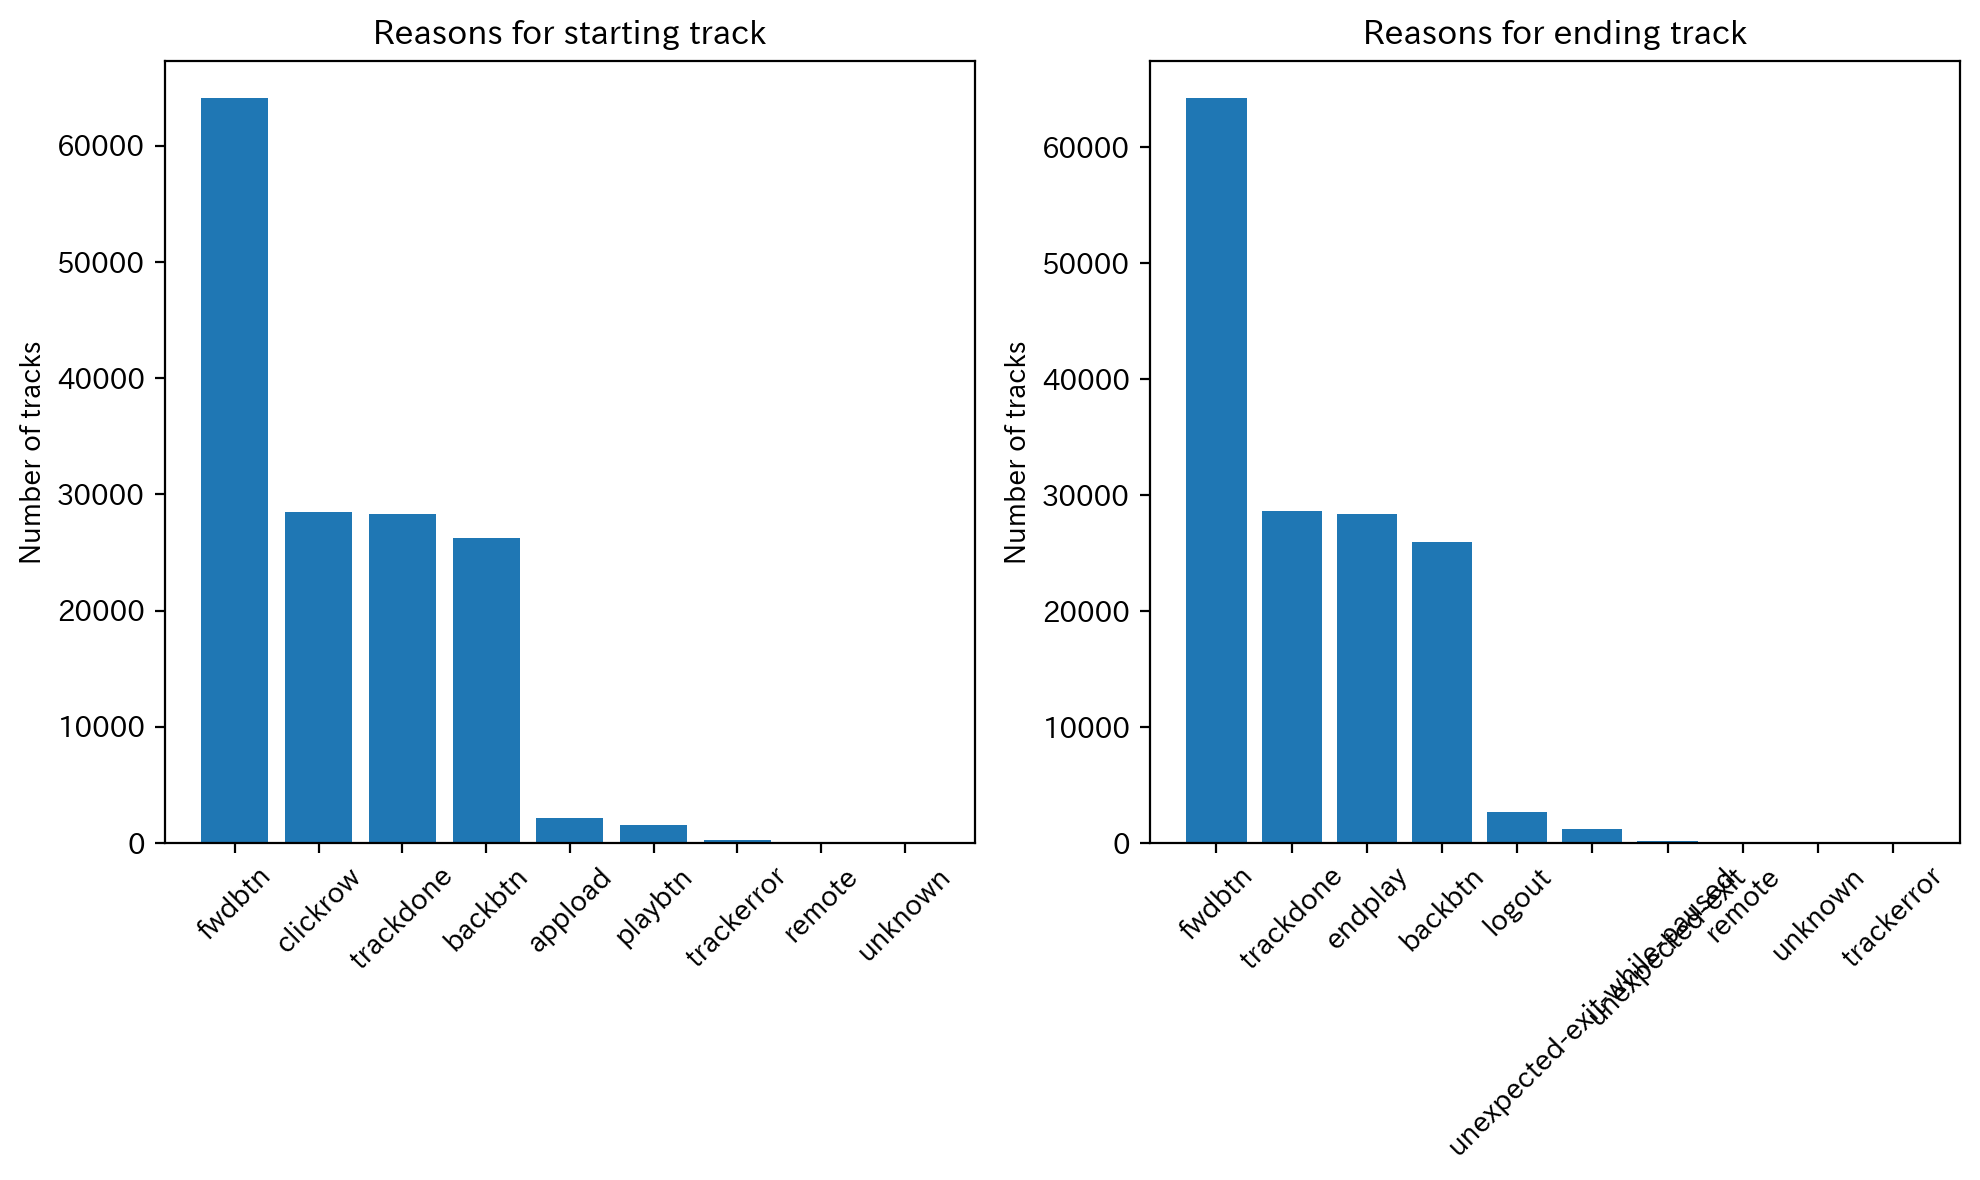

In [1406]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
ax1.bar(all_songs["reason_start"].value_counts().index, all_songs["reason_start"].value_counts())
ax1.set_ylabel("Number of tracks")
ax1.set_title("Reasons for starting track")
ax1.set_xticklabels(all_songs["reason_start"].value_counts().index, rotation=45)

ax2.bar(all_songs["reason_end"].value_counts().index, all_songs["reason_end"].value_counts())
ax2.set_title("Reasons for ending track")
ax2.set_ylabel("Number of tracks")
ax2.set_xticklabels(all_songs["reason_end"].value_counts().index, rotation=45)

fig.tight_layout()

In [1407]:
# all_songs.drop_duplicates(subset = "uri")
all_songs["artist_name"].value_counts()

Anamanaguchi     7213
Daft Punk        6792
Lamp             5225
sasakure.UK      4119
WRLD             4112
                 ... 
Agatha Reilly       1
SiM                 1
Fabian Mazur        1
CORPSE              1
Felix Martin        1
Name: artist_name, Length: 5155, dtype: int64

In [1432]:
dotw = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
hotd = ["00:00", "01:00", "02:00", "03:00", "04:00", "05:00", "06:00", "07:00", 
        "08:00", "09:00", "10:00", "11:00", "12:00", "13:00", "14:00", "15:00", 
        "16:00", "17:00", "18:00", "19:00", "20:00", "21:00", "22:00", "23:00"]

Creating new dataframe to be converted to heatmap

In [1434]:
plays_DOW_per_hour = pd.DataFrame()

for day in range(0, 7):
    temp_day = all_songs["ts"][(all_songs["ts"].dt.dayofweek == day)].dt.hour.value_counts().sort_index()
    plays_DOW_per_hour = plays_DOW_per_hour.append(temp_day, ignore_index = True)


Creating Heatmap for Plays per day of week and hour of day

TypeError: 'dict' object is not callable

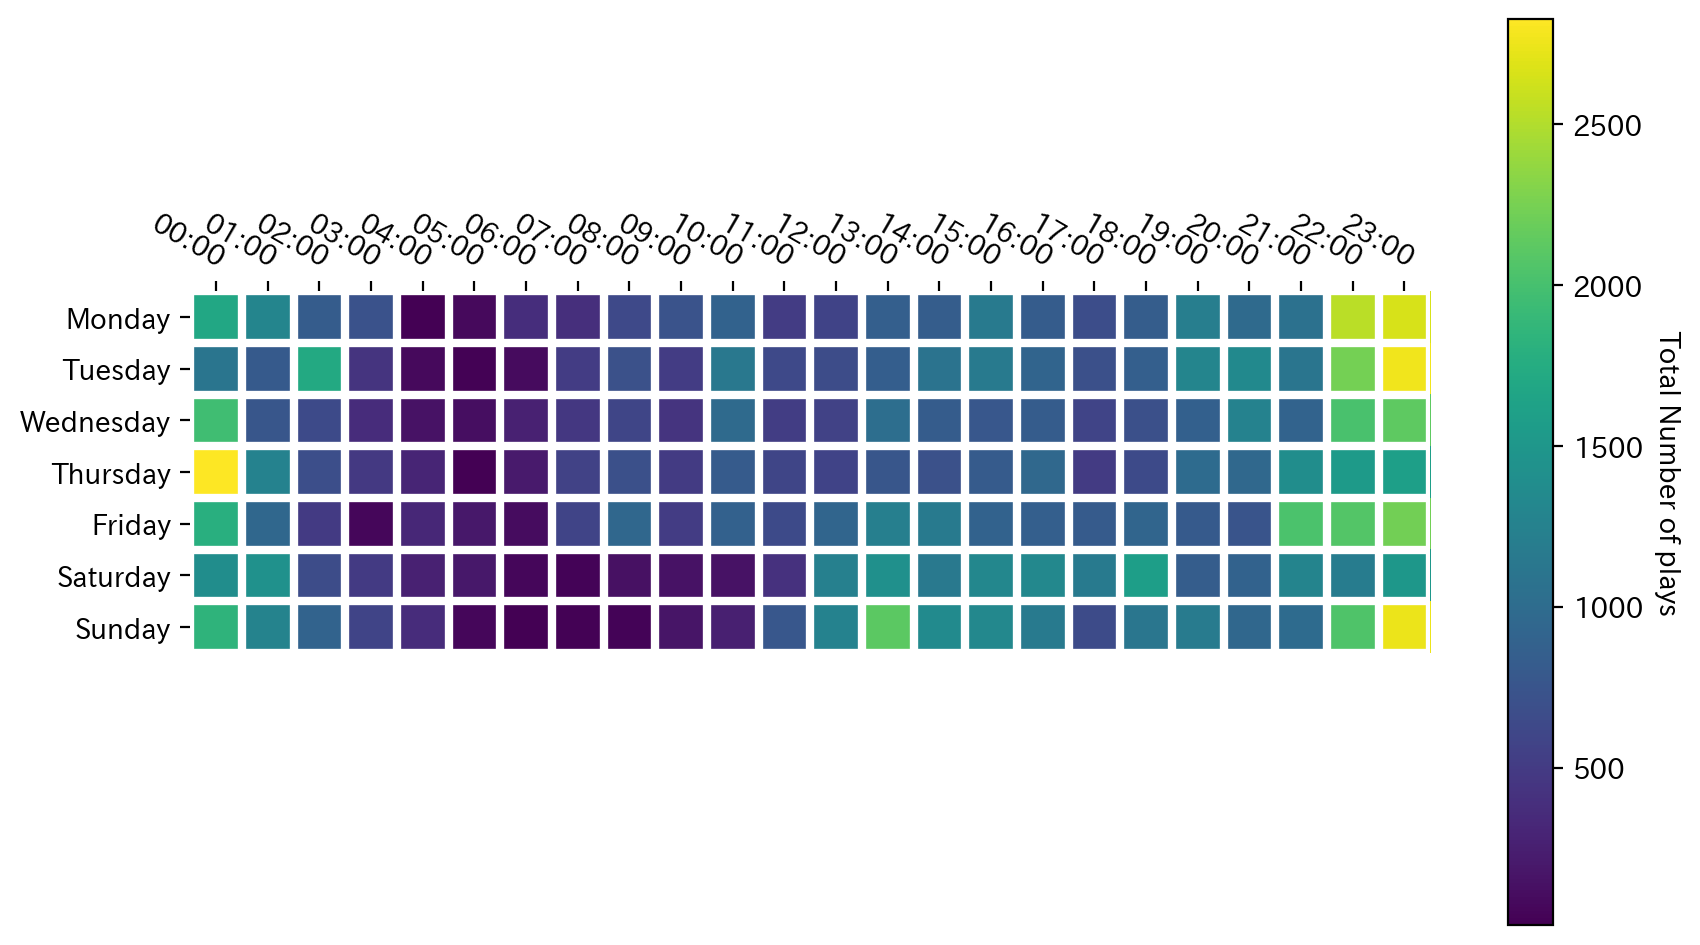

In [1463]:
fig, ax = plt.subplots()
im, cbar = heatmap(plays_DOW_per_hour, dotw, hotd, ax = ax, cbarlabel="Total Number of plays")
texts = annotate_heatmap(im, valfmt="{x:.1f} t")

fig.tight_layout()
plt.show()

Plotting Distribution of Top Artists

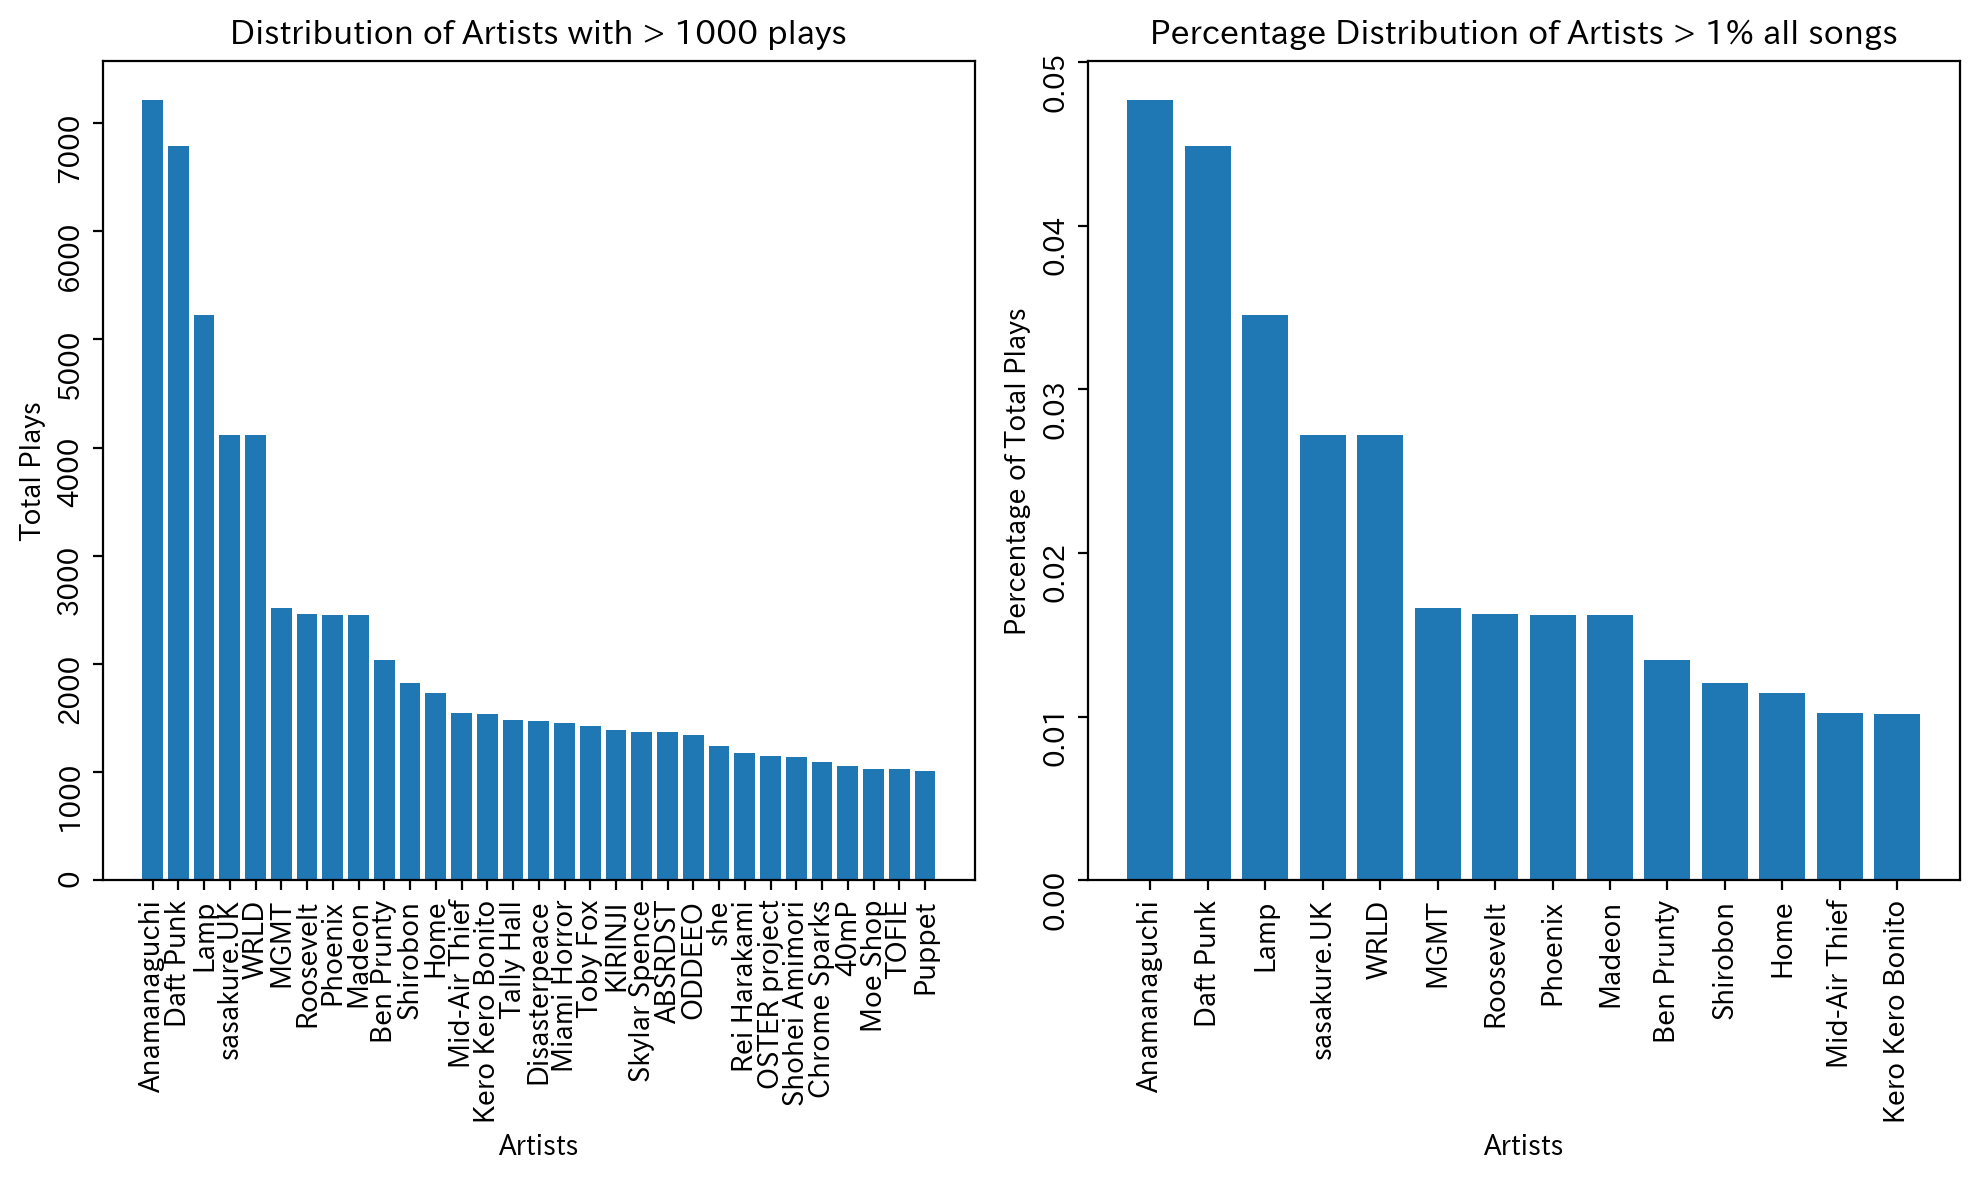

In [1653]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2)
ax1.bar(all_songs["artist_name"].value_counts()[all_songs["artist_name"].value_counts() > 1000].index, all_songs["artist_name"].value_counts()[all_songs["artist_name"].value_counts() > 1000])
ax1.set_xlabel("Artists")
ax1.set_title("Distribution of Artists with > 1000 plays")
ax1.set_ylabel("Total Plays")
ax1.tick_params(labelrotation=90)

ax2.bar(all_songs["artist_name"].value_counts(normalize = True)[all_songs["artist_name"].value_counts(normalize = True) > .01].index, all_songs["artist_name"].value_counts(normalize = True)[all_songs["artist_name"].value_counts(normalize = True) > .01])
ax2.set_xlabel("Artists")
ax2.set_title("Percentage Distribution of Artists > 1% all songs")
ax2.set_ylabel("Percentage of Total Plays")
ax2.tick_params(labelrotation=90)

fig.tight_layout()


Percentage of total plays of artists in top 10 artists

In [1648]:
all_songs["artist_name"].value_counts()

Anamanaguchi     7213
Daft Punk        6792
Lamp             5225
sasakure.UK      4119
WRLD             4112
                 ... 
Agatha Reilly       1
SiM                 1
Fabian Mazur        1
CORPSE              1
Felix Martin        1
Name: artist_name, Length: 5155, dtype: int64

In [1640]:
fig1, ax1 = plt.subplots()
ax1.pie(all_songs["artist_name"].value_counts(normalize = True), labels = all_songs["artist_name"].value_counts(normalize = True).index, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

/usr/local/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 44536 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 47548 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 51088 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 44277 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 46041 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 52404 missing from current font.
  font.set_

KeyboardInterrupt: 

Correlation between hour played and artist

In [1695]:
artist_day_HR = pd.concat([all_songs["artist_name"], all_songs["ts"].dt.dayofweek, all_songs["ts"].dt.hour], ignore_index=True, axis = 1)


In [1696]:
artist_day_HR

,0,1,2
0,Shiro Schwarz,0,2
1,Toby Fox,0,19
2,WRLD,0,21
3,Lamp,6,16
4,Shirobon,3,9
...,...,...,...
16835,Hot Chip,3,0
16836,Local Natives,2,23
16837,sasakure.UK,1,2
16838,Shohei Amimori,4,20


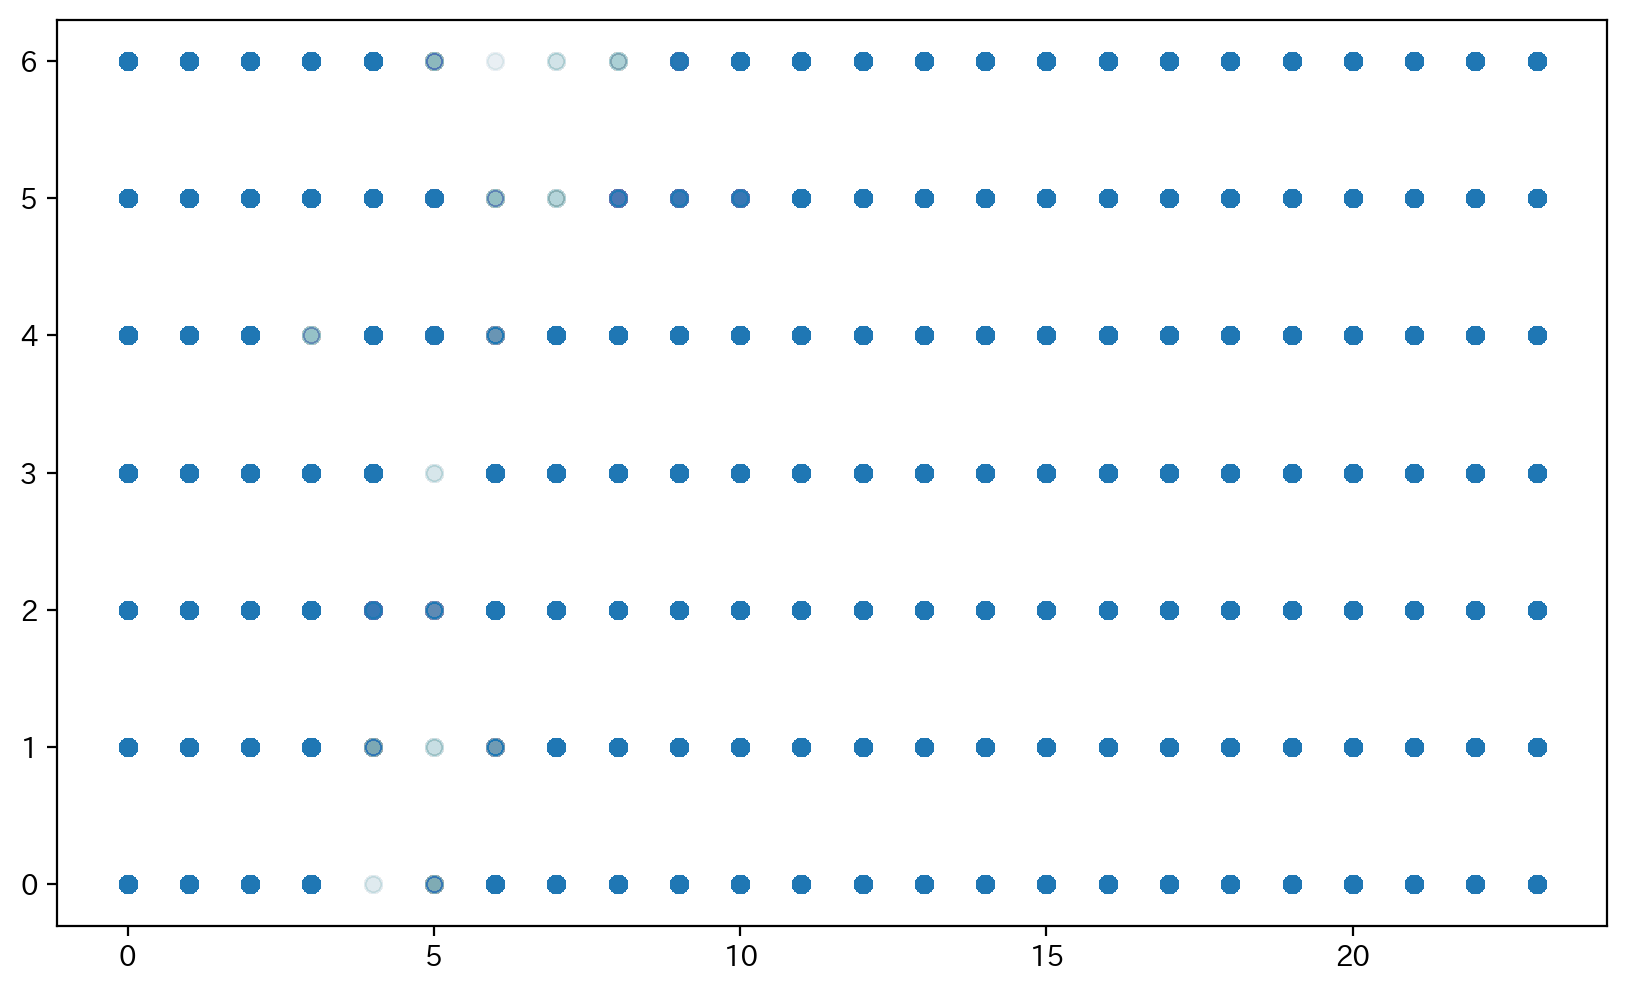

In [1700]:
plt.scatter(artist_day_HR[2], artist_day_HR[1], alpha = 0.009)

Scatter of all songs by date and time

Songs played per day

In [ ]:
fig,ax = plt.subplots()

ax.scatter(most_songs.index, most_songs["Count"])

ax.set(title="Maximum number of songs played in a day", xlabel = "Date", ylabel = "Tracks Played")

ax.axhline(all_songs["track_name"].mean(), linestyle="-", color="r")

Scatterplot of plays per every single hour

In [1717]:
unique_songs = all_songs["track_name"].nunique()
total_songs = all_songs["track_name"].count()
unique_songs_percentage = unique_songs / total_songs * 100
unique_songs_percentage

13.004884432606067